<a href="https://colab.research.google.com/github/rajagopalmotivate1/AILab/blob/master/Copy_of_Design_a_model_dynamically_at_run_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Network architecture search

#My First step towards Neural Architecture Search
## 3 child neural networks are created dynamically on the fly

##Tip: First, Run with epochs=1 to ensure all child networks can run smoothly, Then change to  epochs=10 to improve accuracy of classification

In [2]:
!pip install pydot

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
import tensorflow as tf
from keras import Input
from keras import layers
from keras import datasets
import numpy as np
from keras import utils
from keras.models import  Model
from keras.utils import plot_model
import keras
import os
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from decimal import Decimal
import  matplotlib.pyplot as plt
from scipy.misc import toimage
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from keras.utils import plot_model
from google.colab import files


In [0]:
#Input parameters are depthofnetwork, generalization capacity , 

def createANetwork(ExpNo, noofCNNlayers, noofDenselayers, noofCNNFilters, noofDensenodes  ,
                  networkwidthTamperRate, stride, maxpool, noofPARALLELbranches , kernalsize):
    myinputShape = (32, 32, 3)
    myinputTensor = Input(shape=myinputShape, name='1')
    x = myinputTensor
    layerno = 1
    isskipaddingMaxPool = True
    
    for i in range(noofCNNlayers):
        x = layers.Conv2D(noofCNNFilters, kernel_size=(kernalsize,kernalsize), strides=(stride,stride), activation='relu', name='CNNlayer'+str(layerno)) (x)
        print( str(layerno) + ' Conv2D  Filters=' + str(noofCNNFilters) + '.    kernel size=(' + str(kernalsize) + ' , ' + str(kernalsize) + ' )'  + ' . stride=' + str(stride) + '     Relu')
        x = layers.BatchNormalization()(x)
        layerno = layerno +1
        if(layerno > 3):
            maxpool = 1
        if(layerno > 1):
            stride = 1
        if (isskipaddingMaxPool == False):
            x = layers.MaxPooling2D(pool_size=(maxpool, maxpool), name='MaxPool'+str(layerno)) (x)
            print( str(layerno) + ' MaxPool  . Poolsize=' + str(maxpool) )
            layerno = layerno +1
            x = layers.Dropout(0.2) (x)
            print( '  Dropout 0.2' )
            isskipaddingMaxPool = True
            noofCNNFilters = round( noofCNNFilters * networkwidthTamperRate )
            if(noofCNNFilters>512):
                noofCNNFilters = 512
        else:
            isskipaddingMaxPool = False


    x = layers.Flatten(name='Flatten' + str(layerno) ) (x)
    print(str(layerno) + ' Flatten  ' )

    layerno = layerno + 1

    for i in range(noofDenselayers):
        x = layers.Dense(noofDensenodes, activation='relu', name='Dense'+ str(layerno) )(x)
        print( str(layerno) + ' Dense  ' + str(noofDensenodes) )
        layerno = layerno +1
        noofDensenodes = round(noofDensenodes/2)

    myoutputTensor = layers.Dense(10, activation='softmax', name='DenseMultiClassSoftmaxLayer') (x)

    mymodel = Model(myinputTensor, myoutputTensor)

    
    plot_model(mymodel, show_shapes=False, show_layer_names=True, to_file='achildmodel.png')
    print(mymodel.summary())


    

  #  plot_model(mymodel, show_shapes=True, to_file='models'+str(ExpNo) + '.png')
   # plot_model(mymodel, show_shapes=False, to_file='m'+str(ExpNo) + '.png')


    return mymodel

In [0]:
def create_callbacks(expno):
   # tensorboard_callback = TensorBoard(log_dir=os.path.join(os.getcwd(), "log", "am18d301_Exp1" + str(expno) ), histogram_freq=1, batch_size=32,   write_graph=False, write_grads=False)
   # checkpoint_callback = ModelCheckpoint(filepath="./model-weights.{epoch:02d}.hdf5", monitor='val_acc', verbose=0, save_best_only=True)
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=1, verbose=1, mode='auto')
    return [ earlystop]

In [0]:
def print_model_metrics(model, xtest, ytest ):
    loss, accuracy = model.evaluate(x=xtest, y=ytest)
    print("\n model test loss is "+str(loss)+" accuracy is "+str(accuracy))

    y_softmax = model.predict(xtest)  # this is an n x class matrix of probabilities
    y_hat = y_softmax.argmax(axis=-1)  # this will be the class number.
    test_y = ytest.argmax(axis=-1)  # our test data is also categorical
    print(classification_report(test_y, y_hat))
    return [loss, accuracy]

In [0]:
def plot_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    plt.show()

In [0]:
def convertprecision(alongfloat):
    alongfloat1 = Decimal(alongfloat * 100)
    alongfloat2 = round(alongfloat1, 2)
    myformatedfloat = float(alongfloat2)
    return myformatedfloat 

In [0]:
def runaexpeirment(ExpName, anetworkmodel):

    mymodel = anetworkmodel

    (xtrain1, ytrain1), (xtest, ytest) = datasets.cifar10.load_data()
    
    plot_imgs(xtrain1[:16])

    xtrain  = xtrain1[:42000, :]
    ytrain = ytrain1[:42000, :]

    xval = xtrain1[42000:, :]
    yval = ytrain1[42000:, :]

    datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
    datagen.fit(xtrain)
    

    print( 'Shape of CIFAR Training Set Inputs: ' + str(xtrain.shape) )
    print( 'Shape of CIFAR Training Set Labels: ' + str(ytrain.shape) )
    print( 'Shape of CIFAR Test Set Inputs: ' + str(xtest.shape) )
    print( 'Shape of CIFAR Validation Set Inputs: ' + str(xval.shape) )


    xtrain = xtrain.astype('float16') * 1/255
    xtest = xtest.astype('float16') * 1/255
    xval = xval.astype('float16') * 1/255

    trainSetSize = len(xtrain)
    testSetSize = len(xtest)
    valSetSize = len(xval)

    xtrain = xtrain.reshape((trainSetSize, 32, 32, 3))
    xtest = xtest.reshape((testSetSize, 32, 32, 3))
    xval = xval.reshape((valSetSize,32, 32, 3))

    ytrain = utils.to_categorical(ytrain)
    ytest = utils.to_categorical(ytest)
    yval = utils.to_categorical(yval)

    print('After preprocessing.. normalize to 1, OHE, reshaping')
    print( 'Shape of CIFAR Training Set Inputs: ' + str(xtrain.shape) )
    print( 'Shape of CIFAR Training Set Labels: ' + str(ytrain.shape) )
    print( 'Shape of CIFAR Test Set Inputs: ' + str(xtest.shape) )


    mymodel.compile(optimizer=keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=["accuracy"])

    mycallbacksfunction = create_callbacks(ExpName)

   # history = mymodel.fit(xtrain, ytrain, epochs=2, batch_size=128,
                         # validation_data=(xval,yval),
                         # verbose=1, 
                         # callbacks=mycallbacksfunction
                         # )

    mybatchsize = 128
    history = mymodel.fit_generator( datagen.flow(xtrain, ytrain, batch_size=mybatchsize),
                    steps_per_epoch=xtrain.shape[0] / mybatchsize, 
                    epochs=1,
                    verbose=1,
                    validation_data=(xval,yval)
                      )

    #save to disk
    model_json = mymodel.to_json()
    with open('model' + str(ExpName) + 's.json', 'w') as json_file:
        json_file.write(model_json)
    mymodel.save_weights('model'  + str(ExpName) + 's.h5') 

    myTESTloss, myTESTaccuracy = print_model_metrics( mymodel, xtest, ytest )
    myVALloss, myVALaccuracy = print_model_metrics( mymodel, xval, yval )
    myTRAINloss, myTRAINaccuracy = print_model_metrics( mymodel, xtrain, ytrain)

    myTESTaccuracy = convertprecision(myTESTaccuracy)
    myVALaccuracy = convertprecision(myVALaccuracy)
    myTRAINaccuracy = convertprecision(myTRAINaccuracy)
    

    print(' \n RESULTS')
    print('TRAINING accuracy = ' + str(myTRAINaccuracy ))
    print('VAL accuracy = ' + str(myVALaccuracy))
    print('TEST accuracy = ' + str(myTESTaccuracy))
    
    

    return myTRAINaccuracy, myVALaccuracy, myTESTaccuracy


In [0]:
#Find insights about a network such as how deep is the network, memorizationcapacity, generalizationcapacity, noofCNNs, kernalsize, amountofnonlinearity
def extractNetworkInsights(anetwork):
    print('Analzing the Network insights')
    return 0

### createANetwork() creates a network. Change these values with care. 
#### NOTE: Some values may not yeild a valid model, hence alter with care. And then try with epoch=1 to ensure the model can be trained, else an exception may occur
#### createANetwork(ExpNo, noofCNNlayers, noofDenselayers, noofCNNFilters, noofDensenodes  , noofPARALLELbranches , networkwidthTamperRate)
#####ExpNo- just the experiement serial number.. simply to count how many childs are created
#####noofCNNlayers - no of CNN layers that should be created 
#####noofDenselayers - no of Dense layers that should be created which will usually towards the end of the network
#####noofDensenodes - no of nodes in the Dense layer 
#####noofPARALLELbranches - NOT yet implemented. Future is to use Inception style model with 3 to 4 parallel paths 
#####noofCNNFilters - no of filters in the CNN layers
#####networkwidthTamperRate -  Controls the size of each subsequent layer.  If this is 2, the no of filters in each subsequent CNN layer will be doubled. 





In [0]:
ExpName = 2000
islistcreated = False
ListofNetworks = list()
nooffiltersstarting =  32
networkwidthTamperRate = 2
noofDenselayers = 0
noofDensenodes = 64 
stride = 1
maxpool = 2
noofPARALLELbranches = 1
noofCNNlayers = 6
kernalsize = 3

1 Conv2D  Filters=32.    kernel size=(3 , 3 ) . stride=1     Relu
2 Conv2D  Filters=32.    kernel size=(3 , 3 ) . stride=1     Relu
3 MaxPool  . Poolsize=2
  Dropout 0.2
4 Conv2D  Filters=64.    kernel size=(3 , 3 ) . stride=1     Relu
5 Conv2D  Filters=64.    kernel size=(3 , 3 ) . stride=1     Relu
6 MaxPool  . Poolsize=1
  Dropout 0.2
7 Conv2D  Filters=128.    kernel size=(3 , 3 ) . stride=1     Relu
8 Conv2D  Filters=128.    kernel size=(3 , 3 ) . stride=1     Relu
9 MaxPool  . Poolsize=1
  Dropout 0.2
10 Flatten  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1 (InputLayer)               (None, 32, 32, 3)         0         
_________________________________________________________________
CNNlayer1 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_____________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


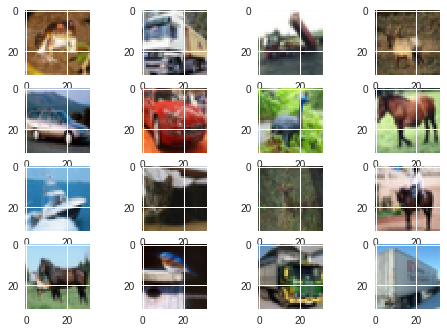

Shape of CIFAR Training Set Inputs: (42000, 32, 32, 3)
Shape of CIFAR Training Set Labels: (42000, 1)
Shape of CIFAR Test Set Inputs: (10000, 32, 32, 3)
Shape of CIFAR Validation Set Inputs: (8000, 32, 32, 3)
After preprocessing.. normalize to 1, OHE, reshaping
Shape of CIFAR Training Set Inputs: (42000, 32, 32, 3)
Shape of CIFAR Training Set Labels: (42000, 10)
Shape of CIFAR Test Set Inputs: (10000, 32, 32, 3)
Epoch 1/1
10000/10000 [==============================] - 2s 207us/step

 model test loss is 3.3708077213287355 accuracy is 0.3157
              precision    recall  f1-score   support

           0       0.51      0.14      0.21      1000
           1       0.35      0.77      0.48      1000
           2       0.22      0.11      0.14      1000
           3       0.29      0.04      0.07      1000
           4       0.24      0.04      0.07      1000
           5       0.47      0.07      0.13      1000
           6       0.22      0.94      0.36      1000
           7       0.

In [15]:
#def createANetwork(ExpNo, noofCNNlayers, noofDenselayers, noofCNNFilters, noofDensenodes  , noofPARALLELbranches , networkwidthTamperRate):

for iterate in range( 0, 1):
  
    ExpName = ExpName + 1
    generatedNetwork =  createANetwork(ExpName, noofCNNlayers,noofDenselayers, nooffiltersstarting, noofDensenodes  ,networkwidthTamperRate, stride, maxpool,  noofPARALLELbranches, kernalsize )

    aTRAINaccuracy, aVALaccuracy, aTESTaccuracy = runaexpeirment(ExpName, generatedNetwork )

    atuple = tuple((ExpName, aTRAINaccuracy, aVALaccuracy, aTESTaccuracy ,  noofCNNlayers,noofDenselayers,  nooffiltersstarting, noofDensenodes  ,networkwidthTamperRate  , stride, maxpool, noofPARALLELbranches , kernalsize, generatedNetwork))

    ListofNetworks.append(atuple)

    print(" ADDED")
    print(atuple)

## This creates 3 models . 
### By changing the value of noofCNNlayers, each time we create a model with different number of layers. 

### In the below values, Initally we create with a CNN with 3 CNN layers, then with 4 CNN layers, then with 5 CNN layers

1 Conv2D  Filters=32.    kernel size=(3 , 3 ) . stride=1     Relu
2 Conv2D  Filters=32.    kernel size=(3 , 3 ) . stride=1     Relu
3 MaxPool  . Poolsize=2
  Dropout 0.2
4 Conv2D  Filters=64.    kernel size=(3 , 3 ) . stride=1     Relu
5 Flatten  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1 (InputLayer)               (None, 32, 32, 3)         0         
_________________________________________________________________
CNNlayer1 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_31 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
CNNlayer2 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_32 (Batc (None, 28, 28, 32)        128       
__________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


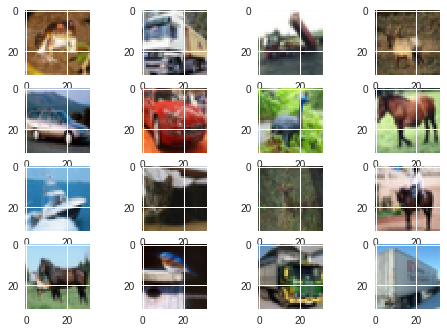

Shape of CIFAR Training Set Inputs: (42000, 32, 32, 3)
Shape of CIFAR Training Set Labels: (42000, 1)
Shape of CIFAR Test Set Inputs: (10000, 32, 32, 3)
Shape of CIFAR Validation Set Inputs: (8000, 32, 32, 3)
After preprocessing.. normalize to 1, OHE, reshaping
Shape of CIFAR Training Set Inputs: (42000, 32, 32, 3)
Shape of CIFAR Training Set Labels: (42000, 10)
Shape of CIFAR Test Set Inputs: (10000, 32, 32, 3)
Epoch 1/1
10000/10000 [==============================] - 2s 156us/step

 model test loss is 2.2467991706848145 accuracy is 0.4264
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      1000
           1       0.33      0.80      0.46      1000
           2       0.53      0.08      0.14      1000
           3       0.38      0.22      0.28      1000
           4       0.46      0.37      0.41      1000
           5       0.53      0.15      0.23      1000
           6       0.60      0.57      0.59      1000
           7       0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


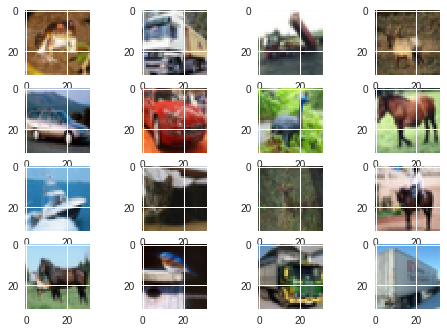

Shape of CIFAR Training Set Inputs: (42000, 32, 32, 3)
Shape of CIFAR Training Set Labels: (42000, 1)
Shape of CIFAR Test Set Inputs: (10000, 32, 32, 3)
Shape of CIFAR Validation Set Inputs: (8000, 32, 32, 3)
After preprocessing.. normalize to 1, OHE, reshaping
Shape of CIFAR Training Set Inputs: (42000, 32, 32, 3)
Shape of CIFAR Training Set Labels: (42000, 10)
Shape of CIFAR Test Set Inputs: (10000, 32, 32, 3)
Epoch 1/1
10000/10000 [==============================] - 2s 173us/step

 model test loss is 2.6329117694854736 accuracy is 0.3841
              precision    recall  f1-score   support

           0       0.65      0.35      0.45      1000
           1       0.40      0.51      0.45      1000
           2       0.45      0.15      0.23      1000
           3       0.29      0.33      0.31      1000
           4       0.49      0.22      0.30      1000
           5       0.43      0.31      0.36      1000
           6       0.67      0.23      0.34      1000
           7       0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


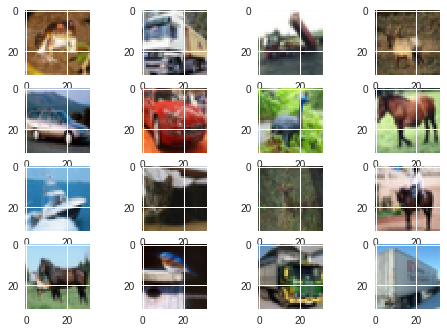

Shape of CIFAR Training Set Inputs: (42000, 32, 32, 3)
Shape of CIFAR Training Set Labels: (42000, 1)
Shape of CIFAR Test Set Inputs: (10000, 32, 32, 3)
Shape of CIFAR Validation Set Inputs: (8000, 32, 32, 3)
After preprocessing.. normalize to 1, OHE, reshaping
Shape of CIFAR Training Set Inputs: (42000, 32, 32, 3)
Shape of CIFAR Training Set Labels: (42000, 10)
Shape of CIFAR Test Set Inputs: (10000, 32, 32, 3)
Epoch 1/1
10000/10000 [==============================] - 2s 196us/step

 model test loss is 2.9446540378570556 accuracy is 0.3222
              precision    recall  f1-score   support

           0       0.56      0.35      0.43      1000
           1       0.30      0.89      0.45      1000
           2       0.35      0.20      0.26      1000
           3       0.18      0.00      0.01      1000
           4       0.29      0.02      0.04      1000
           5       0.50      0.09      0.15      1000
           6       0.23      0.93      0.36      1000
           7       0.

In [18]:
#def createANetwork(ExpNo, noofCNNlayers, noofDenselayers, noofCNNFilters, noofDensenodes  , noofPARALLELbranches , networkwidthTamperRate):


for iterate in range( 3, 6, 1):
  
    noofCNNlayers = iterate 
  
    ExpName = ExpName + 1
    generatedNetwork =  createANetwork(ExpName, noofCNNlayers,noofDenselayers, nooffiltersstarting, noofDensenodes  ,networkwidthTamperRate, stride, maxpool,  noofPARALLELbranches, kernalsize )
    aTRAINaccuracy, aVALaccuracy, aTESTaccuracy = runaexpeirment(ExpName, generatedNetwork )

    atuple = tuple((ExpName, aTRAINaccuracy, aVALaccuracy, aTESTaccuracy ,  noofCNNlayers,noofDenselayers,  nooffiltersstarting, noofDensenodes  ,networkwidthTamperRate  , stride, maxpool, noofPARALLELbranches , kernalsize, generatedNetwork))

    ListofNetworks.append(atuple)

    print(" ADDED")
    print(atuple)

In [0]:
(xtraincheck, ytraincheck), (xtestcheck, ytestcheck) = datasets.cifar10.load_data()
myimageJ = xtraincheck[114]
myimageJnormalized = myimageJ.astype('float16') * 1/255